# Imports

In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
import numpy as np
import torch
import kagglehub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import Dataset
import os
from langdetect import detect
from translator import translate_review, get_translations_count
from deep_translator import GoogleTranslator



# Download the Yelp Review Data from Kaggle


In [3]:
# Load the Yelp Review Dataset from Kaggle
path = kagglehub.dataset_download("omkarsabnis/yelp-reviews-dataset")

print("The path to the downloaded data is the following:", path)

The path to the downloaded data is the following: /Users/sandragedig/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1


In [4]:
# List all files in the directory
directory_path = '/Users/sandragedig/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1'
files = os.listdir(directory_path)
files

['yelp.csv']

In [5]:
# Define the file path for loading the data
file_path = '/Users/sandragedig/.cache/kagglehub/datasets/omkarsabnis/yelp-reviews-dataset/versions/1/yelp.csv'

# Load the dataset
review_df = pd.read_csv(file_path, header=None)

# EDA and Data Preparation

In [6]:
# Take a look how many columns are contained in the df
review_df.shape[0]

10001

In [7]:
# Take a look at the df and see, what needs to be done for data preprocessing
review_df.head()

,0,1,2,3,4,5,6,7,8,9
0,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
4,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0


In [8]:
# Display the column names of the review_df
print(review_df.columns)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')


## Checking, renaming the necessary columns; dropping the unnecessary ones

In [9]:
# Drop unnecessary columns
columns_to_drop = [0, 1, 2, 5, 6, 7, 8, 9]
review_df = review_df.drop(review_df.columns[columns_to_drop], axis=1)

review_df.head()

,3,4
0,stars,text
1,5,My wife took me here on my birthday for breakf...
2,5,I have no idea why some people give bad review...
3,4,love the gyro plate. Rice is so good and I als...
4,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."


In [10]:
# Check the columns in the DataFrame
print(review_df.columns)

Index([3, 4], dtype='int64')


In [11]:
# Rename columns 3 and 4 to "stars" and "review"
review_df.rename(columns={review_df.columns[0]: 'stars', review_df.columns[1]: 'review'}, inplace=True)

# Check the updated DataFrame
print(review_df.head())


   stars                                             review
0  stars                                               text
1      5  My wife took me here on my birthday for breakf...
2      5  I have no idea why some people give bad review...
3      4  love the gyro plate. Rice is so good and I als...
4      5  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...


In [12]:
# Drop the first row (index 0)
review_df.drop(index=0, inplace=True)

# Reset the index to keep it sequential
review_df.reset_index(drop=True, inplace=True)

# Check the updated DataFrame
print(review_df.head())

  stars                                             review
0     5  My wife took me here on my birthday for breakf...
1     5  I have no idea why some people give bad review...
2     4  love the gyro plate. Rice is so good and I als...
3     5  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4     5  General Manager Scott Petello is a good egg!!!...


## Checking and transforming the datatypes

In [13]:
review_df.dtypes

stars     object
review    object
dtype: object

In [14]:
# Convert 'stars' column to int64
review_df['stars'] = review_df['stars'].astype('int64')

# Convert 'review' column to string type (str)
review_df['review'] = review_df['review'].astype('string')

# Check the data types of the columns
print(review_df.dtypes)

stars              int64
review    string[python]
dtype: object


In [15]:
# Überprüfen auf NaN-Werte und leere Strings in der 'review'-Spalte
empty_reviews = review_df[review_df['review'].isna() | (review_df['review'].str.strip() == '')]

# Zeige alle Zeilen mit leeren oder NaN-Werten in der 'review'-Spalte
print("Rows with empty or NaN values in 'review' column:")
print(empty_reviews)

Rows with empty or NaN values in 'review' column:
Empty DataFrame
Columns: [stars, review]
Index: []


## Dealing with the three sentiment categories

In [16]:
# Dividing the ratings into three categories (positive, neutral, negative) for sentiment analysis, 
# as it is designed to detect these three emotions.
# Create a new column 'polarity' based on 'stars'
review_df['polarity'] = review_df['stars'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

review_df.head()

,stars,review,polarity
0,5,My wife took me here on my birthday for breakf...,positive
1,5,I have no idea why some people give bad review...,positive
2,4,love the gyro plate. Rice is so good and I als...,positive
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",positive
4,5,General Manager Scott Petello is a good egg!!!...,positive


In [17]:
review_df['polarity'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

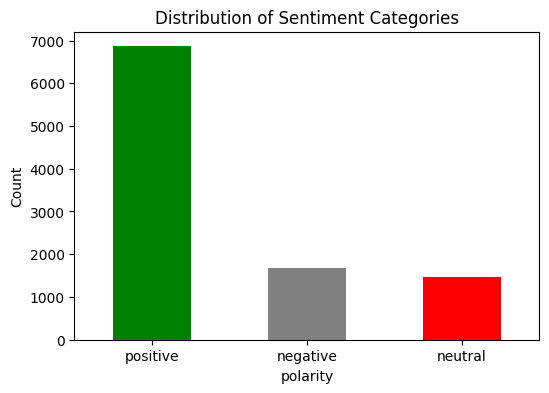

In [ ]:
# Plot the distribution of sentiment categories
plt.figure(figsize=(6,4))
review_df['polarity'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])

# Adding labels and title
plt.title('Distribution of Sentiment Categories')
plt.xlabel('polarity')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Display the plot
plt.show()

## Dealing with the different languages in the review-column

In [ ]:
# Check if all the reviews are in english
review_df['detected_language']=review_df['review'].apply(lambda x: detect(str(x)))
print(review_df["detected_language"].value_counts())

# Calculate the percentage of the reviews, that are not in english
percentage_non_english = review_df["detected_language"].ne("en").mean() * 100
print(f"Percentage of non-English reviews: {percentage_non_english:.2f}%")

detected_language
en    9960
af       6
so       4
it       4
sv       3
cy       3
ca       3
nl       2
sl       2
id       2
fr       2
tl       2
tr       2
no       1
de       1
da       1
pt       1
es       1
Name: count, dtype: int64
Percentage of non-English reviews: 0.40%


In [151]:
# Assuming you have the review_df DataFrame
review_df['translated_review'] = review_df['review'].apply(translate_review)

# Print the DataFrame to see results
print(review_df[['review', 'translated_review']].head())

# Print how many reviews were translated
print(f"Number of translations: {get_translations_count()}")

                                              review  \
0  My wife took me here on my birthday for breakf...   
1  I have no idea why some people give bad review...   
2  love the gyro plate. Rice is so good and I als...   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...   
4  General Manager Scott Petello is a good egg!!!...   

                                   translated_review  
0  My wife took me here on my birthday for breakf...  
1  I have no idea why some people give bad review...  
2  love the gyro plate. Rice is so good and I als...  
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...  
4  General Manager Scott Petello is a good egg!!!...  
Number of translations: 42


In [21]:
review_df

,stars,review,polarity,detected_language,translated_review
0,5,My wife took me here on my birthday for breakf...,positive,en,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...,positive,en,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...,positive,en,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",positive,en,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...,positive,en,General Manager Scott Petello is a good egg!!!...
...,...,...,...,...,...
9995,3,First visit...Had lunch here today - used my G...,neutral,en,First visit...Had lunch here today - used my G...
9996,4,Should be called house of deliciousness! I co...,positive,en,Should be called house of deliciousness!\n\nI ...
9997,4,I recently visited Olive and Ivy for business ...,positive,en,I recently visited Olive and Ivy for business ...
9998,2,My nephew just moved to Scottsdale recently so...,negative,en,My nephew just moved to Scottsdale recently so...


In [93]:
# Check if all the reviews are in english
review_df['detected_language']=review_df['translated_review'].apply(lambda x: detect(str(x)))
print(review_df["detected_language"].value_counts())

# Calculate the percentage of the reviews, that are not in english
percentage_non_english = review_df["detected_language"].ne("en").mean() * 100
print(f"Percentage of non-English reviews: {percentage_non_english:.2f}%")

detected_language
en    9961
af       7
ca       4
so       4
it       3
sv       3
da       2
cy       2
nl       2
id       2
fr       2
tl       2
tr       2
pt       1
ro       1
no       1
es       1
Name: count, dtype: int64
Percentage of non-English reviews: 0.39%


In [154]:
from deep_translator import GoogleTranslator
from langdetect import detect

# Function to translate reviews using Deep Translator
def translate_review(review):
    try:
        if not review:
            return review  # If empty or None, return the original review
        
        # Detect the language of the review
        detected_language = detect(review)
        
        # Translate only if the review is not in English
        if detected_language != 'en':
            translated = GoogleTranslator(source='auto', target='en').translate(review)
            return translated  # Return the translated text
        else:
            return review  # If it's already in English, return the original review
    except Exception as e:
        print(f"Error during translation: {e}")
        return review  # If error occurs, return the original review

# Apply translation to your DataFrame
review_df['translated_review'] = review_df['review'].apply(translate_review)

# Print the DataFrame to see results
print(review_df[['review', 'translated_review']].head())


                                              review  \
0  My wife took me here on my birthday for breakf...   
1  I have no idea why some people give bad review...   
2  love the gyro plate. Rice is so good and I als...   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...   
4  General Manager Scott Petello is a good egg!!!...   

                                   translated_review  
0  My wife took me here on my birthday for breakf...  
1  I have no idea why some people give bad review...  
2  love the gyro plate. Rice is so good and I als...  
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...  
4  General Manager Scott Petello is a good egg!!!...  


In [155]:
# Print how many reviews were translated
print(f"Number of translations: {translations_count}")

NameError: name 'translations_count' is not defined

## Dataset Splitting

In [207]:
# Split the DataFrame into training (80%), validation (10%), and test (10%) sets
train_df, temp_df = train_test_split(review_df, test_size=0.2, random_state=42, stratify=review_df['polarity'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['polarity'])

# Check the lengths of the datasets
print("Train Set Length:", len(train_df))
print("Validation Set Length:", len(val_df))
print("Test Set Length:", len(test_df))

# Optionally, you can save the splits to CSV files for later use
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

Train Set Length: 8000
Validation Set Length: 1000
Test Set Length: 1000


## Tokenisation

In [208]:
# Convert train_df to Hugging Face Dataset format
train_df = Dataset.from_pandas(train_df)
val_df = Dataset.from_pandas(val_df)
test_df = Dataset.from_pandas(test_df)

In [209]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the 'combined_review' column
def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True)

In [210]:
# Tokenize datasets
train_df = train_df.map(tokenize_function, batched=True)
val_df = val_df.map(tokenize_function, batched=True)
test_df = test_df.map(tokenize_function, batched=True)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 1601.79 examples/s]


In [211]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
# We work with 3 output labels for the three emotions categories neutral, positive and negative
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)  


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
